This can be done by running this command on the SMuRF server:

You need to run this in a terminal with X-windows so the server gui can come up.  I typically do this in a VNC session.  On the SMuRF server you can check if a VNC session is running on the command line like this:

This means there's a server up and running on the SMuRF server port 5902, which is the default port I usually start VNC sessions on.  If you don't see any VNC servers up, you can start it by ssh'ing to the machine and entering this command on the command line to start a server on port 5902:

Once the VNC server is up, you can forward this port from the SMuRF server to your machine via ssh like this:

After which you should be able to connect to the VNC server using your viewer by pointing your viewer at `localhost:5902`.

If you've just run the `rfsochammer` command in the VNC session, when it completes, you should get handed a `pysmurf` session in the terminal you ran `rfsochammer` from, and the server gui should pop up in the VNC session, which looks like this:

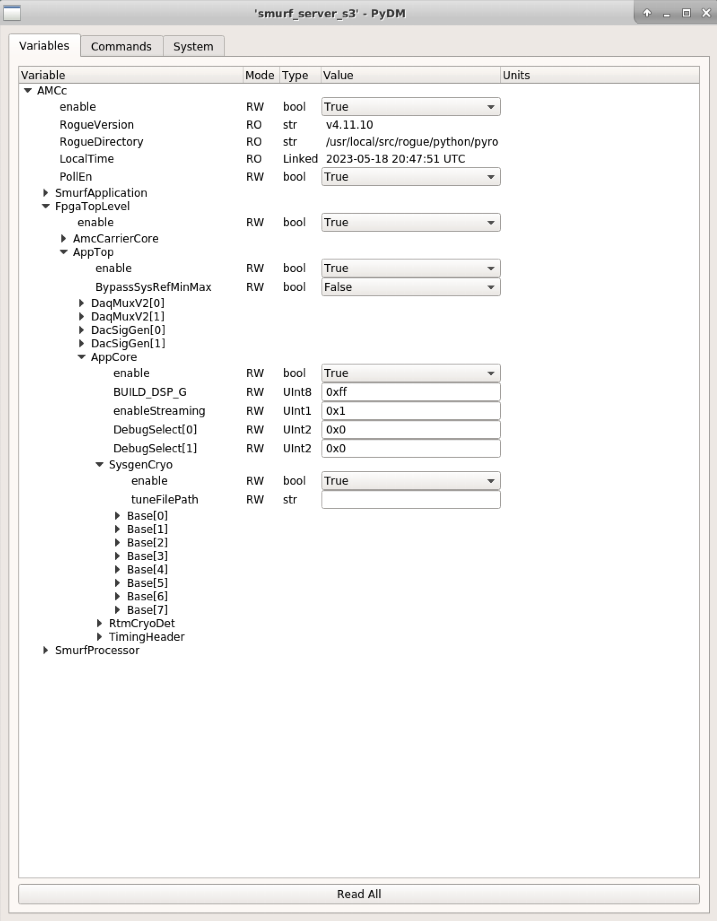

Currently, `rfsochammer` is configured to just start the server and client dockers, but not to do anything else (like run `setDefaults`.  From here, you can either continue to interface with the system through the pysmurf session that comes up in the terminal you ran `rfsochammer` in, or can control it through a jupyter notebook interface like I'm doing here.

The SMuRF server should start in a docker called `smurf_server_s3`.  Here's what it should look like if it started successfully (you can see this by running `docker logs smurf_server_s3` in a terminal session running outside the dockers on the SMuRF server):

# Starting a pysmurf instance

If the SMuRF server is up, you can create a pysmurf control instance like this (I'm also loading some dependencies we often use):

In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import yaml
import time
import pickle as pkl
import os
import numpy as np
from matplotlib import cm
from scipy.signal import welch,periodogram
import pandas as pd
import glob
from scipy.optimize import curve_fit
from scipy import signal

import pysmurf.client
import matplotlib.pylab as plt
import numpy as np
import sys
import os
epics_prefix="smurf_server_s3"
config_file=os.path.abspath("/usr/local/src/pysmurf/cfg_files/lab1/experiment_lab1_rfsoc.cfg")
S = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=False,make_logfile=False,shelf_manager="shm-smrf-sp01")

[ 2025-10-16 01:12:44 ]  ERROR : band 0 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-10-16 01:12:44 ]  ERROR : band 1 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-10-16 01:12:44 ]  ERROR : band 2 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-10-16 01:12:44 ]  ERROR : band 3 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-10-16 01:12:44 ]  ERROR : band 4 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-10-16 01:12:44 ]  ERROR : band 5 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-10-16 01:12:44 ]  ERROR : band 6 is present in pysmurf cfg file, but its bay is not enabled!
[ 2025-10-16 01:12:44 ]  ERROR : band 7 is present in pysmurf cfg file, but its bay is not enabled!


We'll interact with the system through this `S` object from here on.

# Dumping versions

What versions of everything are we running?  This is useful to do at the top of any notebook to track what versions were used:

In [2]:
pysmurf.__version__

'8.0.0-rc3+12.gc1067044.dirty'

What pysmurf branch are we running?

In [3]:
!git branch

* zcu208-devel


In [4]:
S._caget(f'{epics_prefix}:AMCc:RogueVersion', as_string=True)

'v4.11.11'

In [5]:
S._caget(f'{epics_prefix}:AMCc:SmurfApplication:SmurfVersion', as_string=True)

'8.0.0-rc3+12.gc1067044'

In [6]:
S._caget(f'{epics_prefix}:AMCc:SmurfApplication:StartupArguments', as_string=True)

'-g -w smurf_server_s3 -l 1 -d /tmp/fw/smurf_cfg/defaults/defaults_rfsoc_zcu208.yml -e smurf_server_s3 --disable-bay0 --disable-bay1 -a 10.0.1.103'

In [7]:
S.get_fpga_git_hash_short()

'ed145d0'

# Check what tone power corresponds to what

In [8]:
S.which_on(0)

array([  2,   3,   4,   5,   8,  11,  16,  18,  22,  29,  31,  32,  34,
        36,  37,  38,  39,  43,  44,  47,  48,  52,  53,  55,  56,  60,
        68,  72,  74,  76,  77,  79,  80,  82,  83,  85,  87,  88,  89,
        90,  91,  92,  93,  95,  96,  99, 101, 103, 111, 112, 117, 119,
       120, 122, 123, 124, 125, 127, 131, 133, 134, 135, 140, 141, 143,
       146, 151, 154, 155, 159, 160, 164, 165, 166, 167, 168, 170, 172,
       175, 178, 179, 180, 181, 183, 185, 186, 188, 189, 191, 192, 195,
       196, 210, 211, 213, 215, 216, 218, 219, 220, 223, 224, 228, 232,
       234, 240, 243, 244, 245, 249, 250, 252, 255, 258, 260, 261, 263,
       264, 266, 267, 269, 271, 274, 275, 277, 279, 281, 282, 283, 284,
       285, 287, 292, 293, 298, 301, 303, 304, 307, 308, 311, 312, 314,
       317, 319, 320, 322, 324, 330, 331, 333, 335, 336, 338, 339, 341,
       345, 347, 348, 351, 352, 354, 356, 359, 362, 363, 367, 370, 376,
       377, 379, 380, 381, 386, 387, 388, 390, 392, 394, 395, 40

In [9]:
S.set_fixed_tone(4250,12)

(0, 0)

In [13]:
S.which_on(0)

array([0])

In [11]:
S.all_off()

[ 2025-10-16 01:13:43 ]  Turning off tones
[ 2025-10-16 01:14:02 ]  Turning off flux ramp
[ 2025-10-16 01:14:02 ]  Turning off all TES biases


In [14]:
S.set_fixed_tone(4250,12)

AssertionError: ! No unallocated channels available in subband (=255). Doing nothing!

CA.Client.Exception...............................................
    Context: "localhost:5064"
    Source File: ../cac.cpp line 1223
    Current Time: Thu Oct 16 2025 02:04:07.387198554
..................................................................
CA.Client.Exception...............................................
    Context: "localhost:5064"
    Source File: ../cac.cpp line 1223
    Current Time: Thu Oct 16 2025 02:15:14.037883786
..................................................................


In [14]:
S.set_fixed_tone(4333,12)

(0, 324)

In [15]:
S.set_fixed_tone(4100,12)

(0, 387)

In [16]:
S.set_fixed_tone(4200,12)

(0, 215)

In [17]:
S.set_fixed_tone(4450,12)

(0, 458)